In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [11]:
def build_1d_cnn_BN_only_conv(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=8, strides=1, padding='valid', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=8*(2**(i+1)), strides=1, padding='valid'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))

    model.add(Flatten())
    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [12]:
for i in range(1, 6):
    model = build_1d_cnn_BN_only_conv(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 15976, 8)          32        
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 31952)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                511248    
Total params: 511,488
Trainable params: 511,472
Non-trainable params: 16
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
con

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.4395 - acc: 0.2666
Epoch 00001: val_loss improved from inf to 2.07729, saving model to model/checkpoint/1D_CNN_BN_1_only_conv_checkpoint/001-2.0773.hdf5
36805/36805 [==============================] - 10s 278us/sample - loss: 2.4389 - acc: 0.2667 - val_loss: 2.0773 - val_acc: 0.3315
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6488 - acc: 0.4769
Epoch 00002: val_loss improved from 2.07729 to 1.86285, saving model to model/checkpoint/1D_CNN_BN_1_only_conv_checkpoint/002-1.8628.hdf5
36805/36805 [==============================] - 9s 231us/sample - loss: 1.6488 - acc: 0.4769 - val_loss: 1.8628 - val_acc: 0.4249
Epoch 3/500
36672/36805 [============================>.] - ETA: 0s - loss: 1.3517 - acc: 0.5717
Epoch 00003: val_loss improved from 1.86285 to 1.84130, saving model to model/checkp

Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1070 - acc: 0.9849
Epoch 00029: val_loss did not improve from 1.84130
36805/36805 [==============================] - 8s 223us/sample - loss: 0.1071 - acc: 0.9849 - val_loss: 3.2129 - val_acc: 0.4493
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1004 - acc: 0.9872
Epoch 00030: val_loss did not improve from 1.84130
36805/36805 [==============================] - 8s 224us/sample - loss: 0.1004 - acc: 0.9872 - val_loss: 3.2956 - val_acc: 0.4340
Epoch 31/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.0928 - acc: 0.9875
Epoch 00031: val_loss did not improve from 1.84130
36805/36805 [==============================] - 8s 214us/sample - loss: 0.0930 - acc: 0.9873 - val_loss: 3.2926 - val_acc: 0.4458
Epoch 32/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.0940 - acc: 0.9871
Epoch 00032: val_loss did not improve from 1.84130
36805/36805 [========

Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9943
Epoch 00059: val_loss did not improve from 1.84130
36805/36805 [==============================] - 8s 225us/sample - loss: 0.0415 - acc: 0.9943 - val_loss: 4.3423 - val_acc: 0.4235
Epoch 60/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0405 - acc: 0.9947
Epoch 00060: val_loss did not improve from 1.84130
36805/36805 [==============================] - 8s 225us/sample - loss: 0.0405 - acc: 0.9947 - val_loss: 4.3755 - val_acc: 0.4232
Epoch 61/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9968
Epoch 00061: val_loss did not improve from 1.84130
36805/36805 [==============================] - 8s 222us/sample - loss: 0.0331 - acc: 0.9968 - val_loss: 4.3693 - val_acc: 0.4326
Epoch 62/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0435 - acc: 0.9935
Epoch 00062: val_loss did not improve from 1.84130
36805/36805 [========

Epoch 89/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9955
Epoch 00089: val_loss did not improve from 1.84130
36805/36805 [==============================] - 8s 222us/sample - loss: 0.0306 - acc: 0.9955 - val_loss: 4.9043 - val_acc: 0.4237
Epoch 90/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9964
Epoch 00090: val_loss did not improve from 1.84130
36805/36805 [==============================] - 8s 223us/sample - loss: 0.0263 - acc: 0.9964 - val_loss: 4.9008 - val_acc: 0.4212
Epoch 91/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9962
Epoch 00091: val_loss did not improve from 1.84130
36805/36805 [==============================] - 8s 221us/sample - loss: 0.0293 - acc: 0.9962 - val_loss: 4.9536 - val_acc: 0.4160
Epoch 92/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9956
Epoch 00092: val_loss did not improve from 1.84130
36805/36805 [========

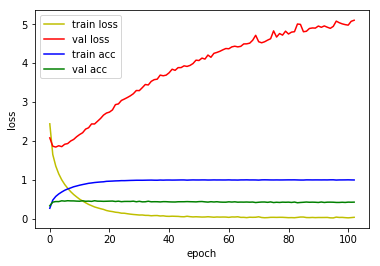

4815/4815 [==============================] - 1s 211us/sample - loss: 1.9023 - acc: 0.4150
Loss: 1.902310560425494 Accuracy: 0.41495326

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3290 - acc: 0.3170
Epoch 00001: val_loss improved from inf to 1.92244, saving model to model/checkpoint/1D_CNN_BN_2_only_conv_checkpoint/001-1.9224.hdf5
36805/36805 [==============================] - 13s 365us/sample - loss: 2.3277 - acc: 0.3174 - val_loss: 1.9224 - val_acc: 0.3823
Epoch 2/500
36672/36805 [============================>.] - ETA: 0s - loss: 1.5560 - acc: 0.5151
Epoch 00002: val_loss improved from 1.92244 to 1.53371, saving model to model/checkpoint/1D_CNN_BN_2_only_conv_checkpoint/002-1.5337.hdf5
36805/36805 [==============================] - 12s 316us/sample - loss: 1.5552 - acc: 0.5153 - val_loss: 1.5337 - val_acc: 0.5243
Epoch 3/500
36672/36805 [============================>.] - ETA: 0s - loss: 1.3223 - acc: 0.

Epoch 58/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0221 - acc: 0.9971
Epoch 00058: val_loss did not improve from 1.38085
36805/36805 [==============================] - 11s 302us/sample - loss: 0.0222 - acc: 0.9970 - val_loss: 3.1239 - val_acc: 0.5667
Epoch 59/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9953
Epoch 00059: val_loss did not improve from 1.38085
36805/36805 [==============================] - 11s 309us/sample - loss: 0.0254 - acc: 0.9952 - val_loss: 3.0521 - val_acc: 0.5733
Epoch 60/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0172 - acc: 0.9982
Epoch 00060: val_loss did not improve from 1.38085
36805/36805 [==============================] - 11s 312us/sample - loss: 0.0172 - acc: 0.9982 - val_loss: 3.0463 - val_acc: 0.5793
Epoch 61/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0138 - acc: 0.9991
Epoch 00061: val_loss did not improve from 1.38085
36805/36805 [=====

Epoch 88/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0177 - acc: 0.9981
Epoch 00088: val_loss did not improve from 1.38085
36805/36805 [==============================] - 11s 312us/sample - loss: 0.0177 - acc: 0.9982 - val_loss: 3.3726 - val_acc: 0.5756
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0178 - acc: 0.9979
Epoch 00089: val_loss did not improve from 1.38085
36805/36805 [==============================] - 12s 317us/sample - loss: 0.0178 - acc: 0.9979 - val_loss: 3.5054 - val_acc: 0.5761
Epoch 90/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9987
Epoch 00090: val_loss did not improve from 1.38085
36805/36805 [==============================] - 12s 313us/sample - loss: 0.0143 - acc: 0.9987 - val_loss: 3.4081 - val_acc: 0.5702
Epoch 91/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0121 - acc: 0.9992
Epoch 00091: val_loss did not improve from 1.38085
36805/36805 [=====

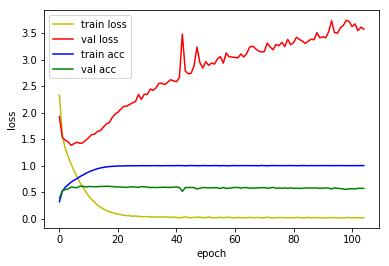

4815/4815 [==============================] - 1s 219us/sample - loss: 1.4395 - acc: 0.5483
Loss: 1.4394703664264699 Accuracy: 0.5482866

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.1988 - acc: 0.3227
Epoch 00001: val_loss improved from inf to 3.76844, saving model to model/checkpoint/1D_CNN_BN_3_only_conv_checkpoint/001-3.7684.hdf5
36805/36805 [==============================] - 16s 432us/sample - loss: 2.1984 - acc: 0.3229 - val_loss: 3.7684 - val_acc: 0.1412
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5327 - acc: 0.5147
Epoch 00002: val_loss improved from 3.76844 to 1.39893, saving model to model/checkpoint/1D_CNN_BN_3_only_conv_checkpoint/002-1.3989.hdf5
36805/36805 [==============================] - 13s 366us/sample - loss: 1.5328 - acc: 0.5146 - val_loss: 1.3989 - val_acc: 0.5670
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3042 - acc: 0.

Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0690 - acc: 0.9895
Epoch 00027: val_loss did not improve from 0.89918
36805/36805 [==============================] - 13s 358us/sample - loss: 0.0691 - acc: 0.9895 - val_loss: 1.1325 - val_acc: 0.7372
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0592 - acc: 0.9912
Epoch 00028: val_loss did not improve from 0.89918
36805/36805 [==============================] - 13s 362us/sample - loss: 0.0594 - acc: 0.9911 - val_loss: 1.0848 - val_acc: 0.7529
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0567 - acc: 0.9906
Epoch 00029: val_loss did not improve from 0.89918
36805/36805 [==============================] - 13s 358us/sample - loss: 0.0567 - acc: 0.9906 - val_loss: 1.1531 - val_acc: 0.7398
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9942
Epoch 00030: val_loss did not improve from 0.89918
36805/36805 [=====

Epoch 57/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0149 - acc: 0.9982
Epoch 00057: val_loss did not improve from 0.89918
36805/36805 [==============================] - 13s 357us/sample - loss: 0.0149 - acc: 0.9982 - val_loss: 1.3966 - val_acc: 0.7545
Epoch 58/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0150 - acc: 0.9983
Epoch 00058: val_loss did not improve from 0.89918
36805/36805 [==============================] - 13s 354us/sample - loss: 0.0151 - acc: 0.9982 - val_loss: 1.4027 - val_acc: 0.7529
Epoch 59/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0201 - acc: 0.9960
Epoch 00059: val_loss did not improve from 0.89918
36805/36805 [==============================] - 13s 357us/sample - loss: 0.0201 - acc: 0.9961 - val_loss: 1.4819 - val_acc: 0.7412
Epoch 60/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0150 - acc: 0.9982
Epoch 00060: val_loss did not improve from 0.89918
36805/36805 [=====

Epoch 87/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0137 - acc: 0.9977
Epoch 00087: val_loss did not improve from 0.89918
36805/36805 [==============================] - 13s 355us/sample - loss: 0.0137 - acc: 0.9977 - val_loss: 1.5679 - val_acc: 0.7522
Epoch 88/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9995
Epoch 00088: val_loss did not improve from 0.89918
36805/36805 [==============================] - 13s 357us/sample - loss: 0.0081 - acc: 0.9995 - val_loss: 1.5260 - val_acc: 0.7598
Epoch 89/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9990
Epoch 00089: val_loss did not improve from 0.89918
36805/36805 [==============================] - 13s 359us/sample - loss: 0.0093 - acc: 0.9990 - val_loss: 1.5419 - val_acc: 0.7650
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9965
Epoch 00090: val_loss did not improve from 0.89918
36805/36805 [=====

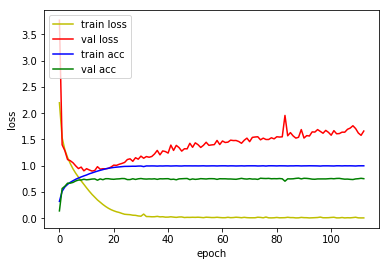

4815/4815 [==============================] - 1s 283us/sample - loss: 0.9750 - acc: 0.7198
Loss: 0.9750070831857366 Accuracy: 0.71983385

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.0002 - acc: 0.3864
Epoch 00001: val_loss improved from inf to 1.95541, saving model to model/checkpoint/1D_CNN_BN_4_only_conv_checkpoint/001-1.9554.hdf5
36805/36805 [==============================] - 19s 515us/sample - loss: 1.9993 - acc: 0.3866 - val_loss: 1.9554 - val_acc: 0.3590
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2072 - acc: 0.6340
Epoch 00002: val_loss improved from 1.95541 to 1.07666, saving model to model/checkpoint/1D_CNN_BN_4_only_conv_checkpoint/002-1.0767.hdf5
36805/36805 [==============================] - 15s 401us/sample - loss: 1.2072 - acc: 0.6340 - val_loss: 1.0767 - val_acc: 0.6685
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9114 - acc: 0

Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0311 - acc: 0.9944
Epoch 00027: val_loss did not improve from 0.41920
36805/36805 [==============================] - 14s 390us/sample - loss: 0.0311 - acc: 0.9944 - val_loss: 0.6102 - val_acc: 0.8602
Epoch 28/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9947
Epoch 00028: val_loss did not improve from 0.41920
36805/36805 [==============================] - 15s 396us/sample - loss: 0.0289 - acc: 0.9947 - val_loss: 0.5312 - val_acc: 0.8805
Epoch 29/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0209 - acc: 0.9969
Epoch 00029: val_loss did not improve from 0.41920
36805/36805 [==============================] - 14s 393us/sample - loss: 0.0210 - acc: 0.9969 - val_loss: 0.5375 - val_acc: 0.8775
Epoch 30/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0270 - acc: 0.9947
Epoch 00030: val_loss did not improve from 0.41920
36805/36805 [=====

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0054 - acc: 0.9994
Epoch 00057: val_loss did not improve from 0.41920
36805/36805 [==============================] - 15s 397us/sample - loss: 0.0054 - acc: 0.9994 - val_loss: 0.5804 - val_acc: 0.8891
Epoch 58/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0046 - acc: 0.9996
Epoch 00058: val_loss did not improve from 0.41920
36805/36805 [==============================] - 15s 397us/sample - loss: 0.0046 - acc: 0.9996 - val_loss: 0.5528 - val_acc: 0.8915
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0046 - acc: 0.9995
Epoch 00059: val_loss did not improve from 0.41920
36805/36805 [==============================] - 14s 393us/sample - loss: 0.0046 - acc: 0.9995 - val_loss: 0.5569 - val_acc: 0.8898
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0185 - acc: 0.9952
Epoch 00060: val_loss did not improve from 0.41920
36805/36805 [=====

Epoch 87/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.9992
Epoch 00087: val_loss did not improve from 0.41920
36805/36805 [==============================] - 15s 394us/sample - loss: 0.0045 - acc: 0.9992 - val_loss: 0.5803 - val_acc: 0.8917
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0088 - acc: 0.9977
Epoch 00088: val_loss did not improve from 0.41920
36805/36805 [==============================] - 15s 396us/sample - loss: 0.0088 - acc: 0.9977 - val_loss: 0.7156 - val_acc: 0.8721
Epoch 89/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0083 - acc: 0.9980
Epoch 00089: val_loss did not improve from 0.41920
36805/36805 [==============================] - 14s 391us/sample - loss: 0.0083 - acc: 0.9980 - val_loss: 0.6891 - val_acc: 0.8737
Epoch 90/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0057 - acc: 0.9986
Epoch 00090: val_loss did not improve from 0.41920
36805/36805 [=====

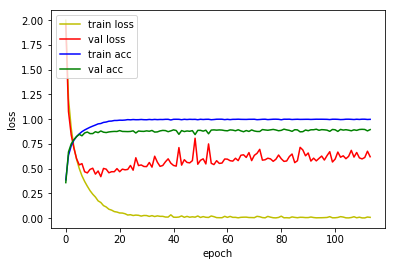

4815/4815 [==============================] - 1s 296us/sample - loss: 0.4896 - acc: 0.8538
Loss: 0.4895778525036567 Accuracy: 0.8537902

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5957 - acc: 0.5104
Epoch 00001: val_loss improved from inf to 2.69424, saving model to model/checkpoint/1D_CNN_BN_5_only_conv_checkpoint/001-2.6942.hdf5
36805/36805 [==============================] - 23s 624us/sample - loss: 1.5956 - acc: 0.5104 - val_loss: 2.6942 - val_acc: 0.2541
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8136 - acc: 0.7517
Epoch 00002: val_loss improved from 2.69424 to 0.64013, saving model to model/checkpoint/1D_CNN_BN_5_only_conv_checkpoint/002-0.6401.hdf5
36805/36805 [==============================] - 16s 435us/sample - loss: 0.8134 - acc: 0.7518 - val_loss: 0.6401 - val_acc: 0.7992
Epoch 3/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.5595 - acc: 0.

Epoch 57/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.9990
Epoch 00057: val_loss did not improve from 0.27289
36805/36805 [==============================] - 15s 415us/sample - loss: 0.0049 - acc: 0.9990 - val_loss: 0.3501 - val_acc: 0.9292
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.9990
Epoch 00058: val_loss did not improve from 0.27289
36805/36805 [==============================] - 15s 414us/sample - loss: 0.0049 - acc: 0.9990 - val_loss: 0.3835 - val_acc: 0.9227
Epoch 59/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9953
Epoch 00059: val_loss did not improve from 0.27289
36805/36805 [==============================] - 15s 411us/sample - loss: 0.0167 - acc: 0.9953 - val_loss: 0.3731 - val_acc: 0.9194
Epoch 60/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0152 - acc: 0.9959
Epoch 00060: val_loss did not improve from 0.27289
36805/36805 [=====

Epoch 87/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0031 - acc: 0.9995
Epoch 00087: val_loss did not improve from 0.27289
36805/36805 [==============================] - 17s 452us/sample - loss: 0.0031 - acc: 0.9995 - val_loss: 0.3427 - val_acc: 0.9278
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9995
Epoch 00088: val_loss did not improve from 0.27289
36805/36805 [==============================] - 16s 448us/sample - loss: 0.0028 - acc: 0.9995 - val_loss: 0.3480 - val_acc: 0.9299
Epoch 89/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0155 - acc: 0.9953
Epoch 00089: val_loss did not improve from 0.27289
36805/36805 [==============================] - 17s 452us/sample - loss: 0.0155 - acc: 0.9954 - val_loss: 0.3673 - val_acc: 0.9222
Epoch 90/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.9992
Epoch 00090: val_loss did not improve from 0.27289
36805/36805 [=====

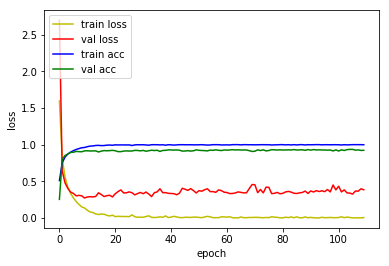

4815/4815 [==============================] - 2s 354us/sample - loss: 0.3738 - acc: 0.8866
Loss: 0.3738165969913003 Accuracy: 0.88660437



In [13]:
for i in range(1, 6):
    model_name = '1D_CNN_BN_{}_only_conv'.format(i)
    model = build_1d_cnn_BN_only_conv(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=100)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [14]:
for i in range(1, 6):
    model_name = '1D_CNN_BN_{}_only_conv'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_BN_1_only_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
batch_normalization_v1_15 (B (None, 15976, 8)          32        
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 31952)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                511248    
Total params: 511,488
Trainable params: 511,472
Non-trainable params: 16
_________________________________________________________________
4815/4815 [==============================] - 1s 295us/sample - loss: 1.9023 - acc: 0.4150
Loss: 1.90231056

4815/4815 [==============================] - 2s 370us/sample - loss: 0.3738 - acc: 0.8866
Loss: 0.3738165969913003 Accuracy: 0.88660437


In [15]:
def build_1d_cnn_BN_DO_only_conv(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=25, filters=8, strides=1, padding='valid', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=8*(2**(i+1)), strides=1, padding='valid'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [16]:
for i in range(1, 6):
    model = build_1d_cnn_BN_only_conv(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
batch_normalization_v1_30 (B (None, 15976, 8)          32        
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 31952)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                511248    
Total params: 511,488
Trainable params: 511,472
Non-trainable params: 16
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
con

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36608/36805 [============================>.] - ETA: 0s - loss: 3.0254 - acc: 0.2082
Epoch 00001: val_loss improved from inf to 2.01469, saving model to model/checkpoint/1D_CNN_BN_DO_1_only_conv_checkpoint/001-2.0147.hdf5
36805/36805 [==============================] - 15s 416us/sample - loss: 3.0230 - acc: 0.2087 - val_loss: 2.0147 - val_acc: 0.3683
Epoch 2/500
36672/36805 [============================>.] - ETA: 0s - loss: 2.0452 - acc: 0.3798
Epoch 00002: val_loss improved from 2.01469 to 1.84213, saving model to model/checkpoint/1D_CNN_BN_DO_1_only_conv_checkpoint/002-1.8421.hdf5
36805/36805 [==============================] - 9s 240us/sample - loss: 2.0447 - acc: 0.3799 - val_loss: 1.8421 - val_acc: 0.4258
Epoch 3/500
36672/36805 [============================>.] - ETA: 0s - loss: 1.7395 - acc: 0.4581
Epoch 00003

Epoch 28/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.7004 - acc: 0.7660
Epoch 00028: val_loss did not improve from 1.68636
36805/36805 [==============================] - 9s 237us/sample - loss: 0.7007 - acc: 0.7661 - val_loss: 1.9949 - val_acc: 0.4976
Epoch 29/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.7005 - acc: 0.7664
Epoch 00029: val_loss did not improve from 1.68636
36805/36805 [==============================] - 9s 237us/sample - loss: 0.7018 - acc: 0.7662 - val_loss: 2.0234 - val_acc: 0.4948
Epoch 30/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.6938 - acc: 0.7685
Epoch 00030: val_loss did not improve from 1.68636
36805/36805 [==============================] - 9s 233us/sample - loss: 0.6940 - acc: 0.7683 - val_loss: 2.0410 - val_acc: 0.4950
Epoch 31/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.6803 - acc: 0.7714
Epoch 00031: val_loss did not improve from 1.68636
36805/36805 [========

Epoch 58/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.5663 - acc: 0.8085
Epoch 00058: val_loss did not improve from 1.68636
36805/36805 [==============================] - 9s 237us/sample - loss: 0.5665 - acc: 0.8085 - val_loss: 2.2712 - val_acc: 0.4938
Epoch 59/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.5563 - acc: 0.8141
Epoch 00059: val_loss did not improve from 1.68636
36805/36805 [==============================] - 9s 234us/sample - loss: 0.5566 - acc: 0.8139 - val_loss: 2.2756 - val_acc: 0.4922
Epoch 60/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.5583 - acc: 0.8114
Epoch 00060: val_loss did not improve from 1.68636
36805/36805 [==============================] - 9s 235us/sample - loss: 0.5580 - acc: 0.8113 - val_loss: 2.2395 - val_acc: 0.4997
Epoch 61/500
36608/36805 [============================>.] - ETA: 0s - loss: 0.5534 - acc: 0.8128
Epoch 00061: val_loss did not improve from 1.68636
36805/36805 [========

Epoch 88/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.4993 - acc: 0.8340
Epoch 00088: val_loss did not improve from 1.68636
36805/36805 [==============================] - 9s 233us/sample - loss: 0.4991 - acc: 0.8340 - val_loss: 2.3179 - val_acc: 0.5087
Epoch 89/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.5053 - acc: 0.8315
Epoch 00089: val_loss did not improve from 1.68636
36805/36805 [==============================] - 9s 233us/sample - loss: 0.5050 - acc: 0.8316 - val_loss: 2.3531 - val_acc: 0.5020
Epoch 90/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.5041 - acc: 0.8312
Epoch 00090: val_loss did not improve from 1.68636
36805/36805 [==============================] - 9s 234us/sample - loss: 0.5040 - acc: 0.8313 - val_loss: 2.3435 - val_acc: 0.5048
Epoch 91/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.4967 - acc: 0.8338
Epoch 00091: val_loss did not improve from 1.68636
36805/36805 [========

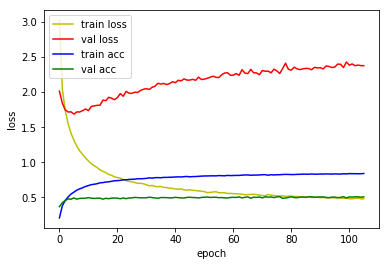

4815/4815 [==============================] - 2s 332us/sample - loss: 1.7871 - acc: 0.4559
Loss: 1.7870784911534991 Accuracy: 0.45586708

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 3.5113 - acc: 0.2055
Epoch 00001: val_loss improved from inf to 2.01016, saving model to model/checkpoint/1D_CNN_BN_DO_2_only_conv_checkpoint/001-2.0102.hdf5
36805/36805 [==============================] - 20s 550us/sample - loss: 3.5096 - acc: 0.2057 - val_loss: 2.0102 - val_acc: 0.3401
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3812 - acc: 0.3602
Epoch 00002: val_loss improved from 2.01016 to 1.79065, saving model to model/checkpoint/1D_CNN_BN_DO_2_only_conv_checkpoint/002-1.7907.hdf5
36805/36805 [==============================] - 12s 319us/sample - loss: 2.3815 - acc: 0.3600 - val_loss: 1.7907 - val_acc: 0.4589
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.9789 - 

Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5880 - acc: 0.8074
Epoch 00025: val_loss improved from 1.11486 to 1.11065, saving model to model/checkpoint/1D_CNN_BN_DO_2_only_conv_checkpoint/025-1.1107.hdf5
36805/36805 [==============================] - 12s 319us/sample - loss: 0.5883 - acc: 0.8074 - val_loss: 1.1107 - val_acc: 0.6986
Epoch 26/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5603 - acc: 0.8141
Epoch 00026: val_loss did not improve from 1.11065
36805/36805 [==============================] - 12s 316us/sample - loss: 0.5607 - acc: 0.8141 - val_loss: 1.1623 - val_acc: 0.6939
Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5396 - acc: 0.8226
Epoch 00027: val_loss did not improve from 1.11065
36805/36805 [==============================] - 12s 317us/sample - loss: 0.5394 - acc: 0.8226 - val_loss: 1.1474 - val_acc: 0.6928
Epoch 28/500
36736/36805 [============================>.] - ETA: 0s - loss: 

Epoch 84/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2394 - acc: 0.9204
Epoch 00084: val_loss did not improve from 1.11065
36805/36805 [==============================] - 12s 318us/sample - loss: 0.2394 - acc: 0.9204 - val_loss: 1.3493 - val_acc: 0.7263
Epoch 85/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2294 - acc: 0.9245
Epoch 00085: val_loss did not improve from 1.11065
36805/36805 [==============================] - 12s 313us/sample - loss: 0.2293 - acc: 0.9244 - val_loss: 1.3192 - val_acc: 0.7195
Epoch 86/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2255 - acc: 0.9241
Epoch 00086: val_loss did not improve from 1.11065
36805/36805 [==============================] - 12s 317us/sample - loss: 0.2261 - acc: 0.9240 - val_loss: 1.3886 - val_acc: 0.7133
Epoch 87/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2314 - acc: 0.9253
Epoch 00087: val_loss did not improve from 1.11065
36805/36805 [=====

Epoch 114/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1924 - acc: 0.9379
Epoch 00114: val_loss did not improve from 1.11065
36805/36805 [==============================] - 12s 317us/sample - loss: 0.1922 - acc: 0.9380 - val_loss: 1.3523 - val_acc: 0.7347
Epoch 115/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1889 - acc: 0.9367
Epoch 00115: val_loss did not improve from 1.11065
36805/36805 [==============================] - 12s 315us/sample - loss: 0.1895 - acc: 0.9366 - val_loss: 1.3654 - val_acc: 0.7331
Epoch 116/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1932 - acc: 0.9372
Epoch 00116: val_loss did not improve from 1.11065
36805/36805 [==============================] - 11s 311us/sample - loss: 0.1932 - acc: 0.9372 - val_loss: 1.4394 - val_acc: 0.7263
Epoch 117/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2063 - acc: 0.9310
Epoch 00117: val_loss did not improve from 1.11065
36805/36805 [=

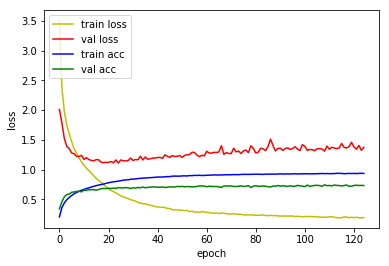

4815/4815 [==============================] - 2s 354us/sample - loss: 1.2079 - acc: 0.6586
Loss: 1.2078924180315043 Accuracy: 0.65856695

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 3.1552 - acc: 0.2279
Epoch 00001: val_loss improved from inf to 3.31004, saving model to model/checkpoint/1D_CNN_BN_DO_3_only_conv_checkpoint/001-3.3100.hdf5
36805/36805 [==============================] - 23s 627us/sample - loss: 3.1535 - acc: 0.2280 - val_loss: 3.3100 - val_acc: 0.1854
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.0248 - acc: 0.4295
Epoch 00002: val_loss improved from 3.31004 to 1.31739, saving model to model/checkpoint/1D_CNN_BN_DO_3_only_conv_checkpoint/002-1.3174.hdf5
36805/36805 [==============================] - 13s 343us/sample - loss: 2.0244 - acc: 0.4296 - val_loss: 1.3174 - val_acc: 0.6047
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.6143 - 

Epoch 52/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2054 - acc: 0.9324
Epoch 00052: val_loss did not improve from 0.50125
36805/36805 [==============================] - 13s 342us/sample - loss: 0.2055 - acc: 0.9324 - val_loss: 0.5519 - val_acc: 0.8707
Epoch 53/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2033 - acc: 0.9338
Epoch 00053: val_loss did not improve from 0.50125
36805/36805 [==============================] - 13s 341us/sample - loss: 0.2034 - acc: 0.9338 - val_loss: 0.5370 - val_acc: 0.8740
Epoch 54/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2022 - acc: 0.9338
Epoch 00054: val_loss did not improve from 0.50125
36805/36805 [==============================] - 13s 341us/sample - loss: 0.2023 - acc: 0.9338 - val_loss: 0.5701 - val_acc: 0.8647
Epoch 55/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1973 - acc: 0.9353
Epoch 00055: val_loss did not improve from 0.50125
36805/36805 [=====

Epoch 82/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1428 - acc: 0.9530
Epoch 00082: val_loss did not improve from 0.50125
36805/36805 [==============================] - 13s 341us/sample - loss: 0.1426 - acc: 0.9530 - val_loss: 0.5553 - val_acc: 0.8821
Epoch 83/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1347 - acc: 0.9552
Epoch 00083: val_loss did not improve from 0.50125
36805/36805 [==============================] - 13s 343us/sample - loss: 0.1350 - acc: 0.9553 - val_loss: 0.5680 - val_acc: 0.8740
Epoch 84/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1395 - acc: 0.9534
Epoch 00084: val_loss did not improve from 0.50125
36805/36805 [==============================] - 13s 342us/sample - loss: 0.1396 - acc: 0.9534 - val_loss: 0.5756 - val_acc: 0.8754
Epoch 85/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1335 - acc: 0.9553
Epoch 00085: val_loss did not improve from 0.50125
36805/36805 [=====

Epoch 112/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1108 - acc: 0.9622
Epoch 00112: val_loss did not improve from 0.50125
36805/36805 [==============================] - 13s 342us/sample - loss: 0.1108 - acc: 0.9623 - val_loss: 0.5934 - val_acc: 0.8777
Epoch 113/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1144 - acc: 0.9615
Epoch 00113: val_loss did not improve from 0.50125
36805/36805 [==============================] - 13s 342us/sample - loss: 0.1144 - acc: 0.9615 - val_loss: 0.6040 - val_acc: 0.8784
Epoch 114/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1153 - acc: 0.9615
Epoch 00114: val_loss did not improve from 0.50125
36805/36805 [==============================] - 13s 342us/sample - loss: 0.1154 - acc: 0.9615 - val_loss: 0.5752 - val_acc: 0.8821
Epoch 115/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1112 - acc: 0.9628
Epoch 00115: val_loss did not improve from 0.50125
36805/36805 [=

Epoch 142/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0991 - acc: 0.9675
Epoch 00142: val_loss did not improve from 0.50125
36805/36805 [==============================] - 13s 344us/sample - loss: 0.0989 - acc: 0.9675 - val_loss: 0.6169 - val_acc: 0.8782

1D_CNN_BN_DO_3_only_conv Model


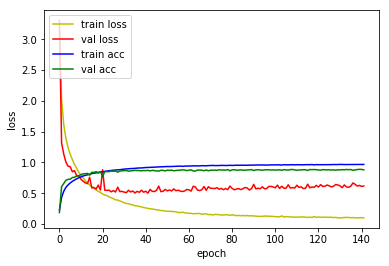

4815/4815 [==============================] - 2s 406us/sample - loss: 0.5594 - acc: 0.8538
Loss: 0.5594111439099811 Accuracy: 0.8537902

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 3.0288 - acc: 0.2362
Epoch 00001: val_loss improved from inf to 4.79983, saving model to model/checkpoint/1D_CNN_BN_DO_4_only_conv_checkpoint/001-4.7998.hdf5
36805/36805 [==============================] - 27s 728us/sample - loss: 3.0263 - acc: 0.2366 - val_loss: 4.7998 - val_acc: 0.1379
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9429 - acc: 0.4286
Epoch 00002: val_loss improved from 4.79983 to 1.22896, saving model to model/checkpoint/1D_CNN_BN_DO_4_only_conv_checkpoint/002-1.2290.hdf5
36805/36805 [==============================] - 14s 378us/sample - loss: 1.9428 - acc: 0.4286 - val_loss: 1.2290 - val_acc: 0.6180
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.5312 - a

36736/36805 [============================>.] - ETA: 0s - loss: 0.2128 - acc: 0.9303
Epoch 00024: val_loss did not improve from 0.25062
36805/36805 [==============================] - 14s 373us/sample - loss: 0.2130 - acc: 0.9302 - val_loss: 0.2623 - val_acc: 0.9250
Epoch 25/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2059 - acc: 0.9349
Epoch 00025: val_loss did not improve from 0.25062
36805/36805 [==============================] - 14s 376us/sample - loss: 0.2064 - acc: 0.9346 - val_loss: 0.2598 - val_acc: 0.9280
Epoch 26/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2011 - acc: 0.9347
Epoch 00026: val_loss improved from 0.25062 to 0.24860, saving model to model/checkpoint/1D_CNN_BN_DO_4_only_conv_checkpoint/026-0.2486.hdf5
36805/36805 [==============================] - 14s 374us/sample - loss: 0.2012 - acc: 0.9346 - val_loss: 0.2486 - val_acc: 0.9313
Epoch 27/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1911 - acc:

Epoch 81/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0561 - acc: 0.9821
Epoch 00081: val_loss did not improve from 0.23479
36805/36805 [==============================] - 14s 373us/sample - loss: 0.0561 - acc: 0.9821 - val_loss: 0.2883 - val_acc: 0.9366
Epoch 82/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0601 - acc: 0.9795
Epoch 00082: val_loss did not improve from 0.23479
36805/36805 [==============================] - 14s 374us/sample - loss: 0.0602 - acc: 0.9794 - val_loss: 0.2710 - val_acc: 0.9362
Epoch 83/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0581 - acc: 0.9808
Epoch 00083: val_loss did not improve from 0.23479
36805/36805 [==============================] - 14s 375us/sample - loss: 0.0581 - acc: 0.9808 - val_loss: 0.2811 - val_acc: 0.9369
Epoch 84/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0594 - acc: 0.9800
Epoch 00084: val_loss did not improve from 0.23479
36805/36805 [=====

Epoch 111/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0436 - acc: 0.9851
Epoch 00111: val_loss did not improve from 0.23479
36805/36805 [==============================] - 14s 375us/sample - loss: 0.0438 - acc: 0.9851 - val_loss: 0.2698 - val_acc: 0.9408
Epoch 112/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9828
Epoch 00112: val_loss did not improve from 0.23479
36805/36805 [==============================] - 14s 376us/sample - loss: 0.0544 - acc: 0.9828 - val_loss: 0.2844 - val_acc: 0.9406
Epoch 113/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9864
Epoch 00113: val_loss did not improve from 0.23479
36805/36805 [==============================] - 14s 376us/sample - loss: 0.0411 - acc: 0.9864 - val_loss: 0.2925 - val_acc: 0.9422
Epoch 114/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9852
Epoch 00114: val_loss did not improve from 0.23479
36805/36805 [=

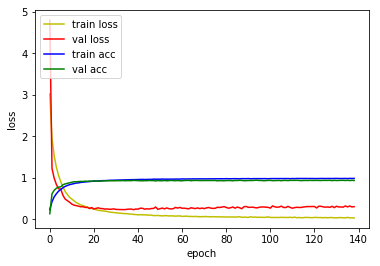

4815/4815 [==============================] - 2s 409us/sample - loss: 0.3009 - acc: 0.9169
Loss: 0.30086840958114974 Accuracy: 0.91692626

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6689 - acc: 0.2896
Epoch 00001: val_loss improved from inf to 4.54738, saving model to model/checkpoint/1D_CNN_BN_DO_5_only_conv_checkpoint/001-4.5474.hdf5
36805/36805 [==============================] - 28s 761us/sample - loss: 2.6687 - acc: 0.2897 - val_loss: 4.5474 - val_acc: 0.1689
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.5197 - acc: 0.5347
Epoch 00002: val_loss improved from 4.54738 to 0.87122, saving model to model/checkpoint/1D_CNN_BN_DO_5_only_conv_checkpoint/002-0.8712.hdf5
36805/36805 [==============================] - 15s 405us/sample - loss: 1.5191 - acc: 0.5349 - val_loss: 0.8712 - val_acc: 0.7321
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1081 -

Epoch 53/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9883
Epoch 00053: val_loss did not improve from 0.20277
36805/36805 [==============================] - 16s 428us/sample - loss: 0.0374 - acc: 0.9883 - val_loss: 0.2467 - val_acc: 0.9425
Epoch 54/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0459 - acc: 0.9858
Epoch 00054: val_loss did not improve from 0.20277
36805/36805 [==============================] - 16s 430us/sample - loss: 0.0459 - acc: 0.9859 - val_loss: 0.2572 - val_acc: 0.9383
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9862
Epoch 00055: val_loss did not improve from 0.20277
36805/36805 [==============================] - 16s 434us/sample - loss: 0.0426 - acc: 0.9862 - val_loss: 0.2321 - val_acc: 0.9434
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0492 - acc: 0.9843
Epoch 00056: val_loss did not improve from 0.20277
36805/36805 [=====

Epoch 83/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0238 - acc: 0.9925
Epoch 00083: val_loss did not improve from 0.20277
36805/36805 [==============================] - 16s 429us/sample - loss: 0.0238 - acc: 0.9924 - val_loss: 0.2669 - val_acc: 0.9455
Epoch 84/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9920
Epoch 00084: val_loss did not improve from 0.20277
36805/36805 [==============================] - 16s 426us/sample - loss: 0.0262 - acc: 0.9920 - val_loss: 0.2570 - val_acc: 0.9450
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9865
Epoch 00085: val_loss did not improve from 0.20277
36805/36805 [==============================] - 16s 430us/sample - loss: 0.0412 - acc: 0.9865 - val_loss: 0.2604 - val_acc: 0.9450
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9926
Epoch 00086: val_loss did not improve from 0.20277
36805/36805 [=====

Epoch 113/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.0348 - acc: 0.9887
Epoch 00113: val_loss did not improve from 0.20277
36805/36805 [==============================] - 16s 428us/sample - loss: 0.0347 - acc: 0.9887 - val_loss: 0.2591 - val_acc: 0.9448
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9929
Epoch 00114: val_loss did not improve from 0.20277
36805/36805 [==============================] - 16s 428us/sample - loss: 0.0232 - acc: 0.9929 - val_loss: 0.2637 - val_acc: 0.9448
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0180 - acc: 0.9942
Epoch 00115: val_loss did not improve from 0.20277
36805/36805 [==============================] - 16s 429us/sample - loss: 0.0183 - acc: 0.9941 - val_loss: 0.2623 - val_acc: 0.9485
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9920
Epoch 00116: val_loss did not improve from 0.20277
36805/36805 [=

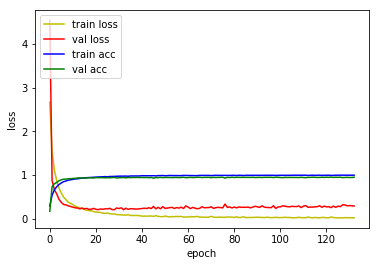

4815/4815 [==============================] - 2s 469us/sample - loss: 0.2710 - acc: 0.9221
Loss: 0.2710222844517986 Accuracy: 0.92211837



In [17]:
for i in range(1, 6):
    model_name = '1D_CNN_BN_DO_{}_only_conv'.format(i)
    model = build_1d_cnn_BN_DO_only_conv(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=100)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [18]:
for i in range(1, 6):
    model_name = '1D_CNN_BN_DO_{}_only_conv'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_BN_DO_1_only_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 15976, 8)          32        
_________________________________________________________________
max_pooling1d_60 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 31952)             0         
_________________________________________________________________
dropout (Dropout)            (None, 31952)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                511248    
Total params: 511,488
Trainable params: 511,472
Non-trainable params: 16
_____________________________________

4815/4815 [==============================] - 3s 550us/sample - loss: 0.2710 - acc: 0.9221
Loss: 0.2710222844517986 Accuracy: 0.92211837
